In [1]:
import pickle
import datetime as dt
import pandas as pd
import numpy as np
import glob, os
import re
import json
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from scipy.stats import entropy
from scipy.stats import mannwhitneyu,ttest_ind
from math import log, e

In [2]:
###READING BIPOLAR DATA
bipolar_data = pd.read_pickle("/Users/tanjakemper/Documents/Bipolar Project/datasets/bipolar_data/bipolar_data_all_tweets.pkl", compression='infer')

In [3]:
bipolar_data.drop('full_text',inplace=True,axis=1)
bipolar_data.head()

,id,is_control,created_at
0,1039634572034678784,0,2018-11-17 02:29:33
1,1039634572034678784,0,2018-11-17 02:28:34
2,1039634572034678784,0,2018-11-17 02:27:02
3,1039634572034678784,0,2018-11-17 02:25:24
4,1039634572034678784,0,2018-11-17 02:23:17


In [4]:
bipolar_data.head(10)

,id,is_control,created_at
0,1039634572034678784,0,2018-11-17 02:29:33
1,1039634572034678784,0,2018-11-17 02:28:34
2,1039634572034678784,0,2018-11-17 02:27:02
3,1039634572034678784,0,2018-11-17 02:25:24
4,1039634572034678784,0,2018-11-17 02:23:17
5,1039634572034678784,0,2018-11-17 02:21:04
6,1039634572034678784,0,2018-11-17 02:19:28
7,1039634572034678784,0,2018-09-15 00:34:01
8,1039634572034678784,0,2018-09-11 22:12:33
9,1039634572034678784,0,2018-09-11 22:11:51


In [5]:
bipolar_data.count()

id            2895363
is_control    2895363
created_at    2895363
dtype: int64

In [6]:
control_data = pd.read_pickle("/Users/tanjakemper/Documents/Bipolar Project/datasets/control_data/1/control_data_all_tweets.pkl", compression='infer')

In [7]:
control_data.head(5)

,id,is_control,created_at,full_text
0,185501402,1,2019-04-18 07:13:47,RT @menghanyurkan: let’s confuse kids nowadays...
1,185501402,1,2019-04-17 04:04:24,RT @awwe_: Ok PSI u got my vote. Good luck.
2,185501402,1,2019-03-31 17:33:40,RT @LFC: This TEAM 🔴🔴 https://t.co/MTfxRUnenK
3,185501402,1,2019-03-31 17:33:29,RT @LFC: Up the Reds 🙌🔴 https://t.co/1dLVql61sz
4,185501402,1,2019-03-31 17:32:51,"RT @LFCUSA: Boston, they can hear you all the ..."


In [9]:
control_data.count()

id            7516454
is_control    7516454
created_at    7516454
dtype: int64

In [9]:
###ADDITIONAL COLUMNS: HOUR AND MINUTE
bipolar_data['hour'] = pd.to_datetime(bipolar_data['created_at'], format='%H:%M').dt.hour
bipolar_data['minute'] = pd.to_datetime(bipolar_data['created_at'], format='%H:%M').dt.minute
control_data['hour'] = pd.to_datetime(control_data['created_at'], format='%H:%M').dt.hour
control_data['minute'] = pd.to_datetime(control_data['created_at'], format='%H:%M').dt.minute
control_data.sample(5, random_state=0)

,id,is_control,created_at,full_text,hour,minute
2952528,302854411,1,2019-02-18 19:12:44,@RoyalKenyah My Strawberry will come and say i...,19,12
1640827,1728285067,1,2018-01-29 12:03:56,I wish I wasn't broke so I could play monster ...,12,3
2077996,545010449,1,2013-09-16 11:16:08,The longest river in the world is the Nile Riv...,11,16
2934199,541157654,1,2015-02-18 22:16:29,@matthewmcvey Yea that's cool,22,16
2637216,63323676,1,2017-05-22 19:32:13,RT @TeamRocket: Retweet if you find Ditto http...,19,32


In [10]:
###SET DATE AS AN INDEX
bipolar_data = bipolar_data.set_index('created_at')
control_data = control_data.set_index('created_at')

In [11]:
### FILTER OUT TWEETS BEFORE 2015
bipolar_data2013 = bipolar_data[(bipolar_data.index >= '2013-1-1 01:00:00')]
control_data2013 = control_data[(control_data.index >= '2013-1-1 01:00:00')]

In [21]:
### FOR OVERVIEW: COUNT USERS PER YEAR, POSTS PER YEAR, MEAN POSTS OF USER PER YEAR
#control_data[('2018-1-1 01:00:00' <= control_data.index) & (control_data.index <= '2019-1-1 01:00:00')]
#control_data[('2019-1-1 01:00:00' <= control_data.index)].groupby('id').mean()
#control_data[('2013-1-1 01:00:00' <= control_data.index) & (control_data.index <= '2014-1-1 01:00:00')].groupby('id').mean()

## ENTROPY CONTROL & BIPOLAR GROUPS

In [20]:
### ENTROPY FUNCTION
def entropy1(labels, base=None):
    """computes entropy of vector of numbers (for example, hour of tweeting)"""
    # Transform raw values into counts per bin (hour of tweeting)
    value,counts = np.unique(labels, return_counts=True)
    return entropy(counts, base=base)

In [21]:
# group dataframe by individual user + FILTER OUT USERS WITH LESS THAN 1000 TWEETS:
control_id_groups =  control_data2013.groupby('id').filter(lambda x: len(x) > 1000)
filtered_control = control_id_groups.groupby('id')
bipolar_id_groups =  bipolar_data2013.groupby('id').filter(lambda x: len(x) > 1000)
filtered_bipolar = bipolar_id_groups.groupby('id')

In [22]:
## ENTROPY CONTROL
filtered_control.aggregate(entropy1)['hour'].mean()

2.857216728908001

In [23]:
## ENTROPY BIPOLAR
filtered_bipolar.aggregate(entropy1)['hour'].mean()

2.9110992417776766

In [24]:
# Vector of individual-specific entropy values of bipolar group:
bipolar_entropy_vec = filtered_bipolar.aggregate(entropy1)['hour']
control_entropy_vec = filtered_control.aggregate(entropy1)['hour']

In [25]:
#nonparametric test of difference between bipolar and control users regarding their entropy:
mannwhitneyu(bipolar_entropy_vec,control_entropy_vec)
# ==> p-value<.05 (Kolmogorov-Smirnov Test)

MannwhitneyuResult(statistic=849662.0, pvalue=0.00040111024592024607)

In [26]:
#t-test
ttest_ind(bipolar_entropy_vec,control_entropy_vec)

Ttest_indResult(statistic=6.482584216746171, pvalue=1.0671231147953156e-10)

# FILTER USERS WITH ENOUGH POSTS (POSTS+MONTHS) ###




In [27]:
### CONCAT DATASETS
all_data = pd.concat([control_id_groups, bipolar_id_groups])
all_data.sample(5, random_state=0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,full_text,hour,id,is_control,minute
created_at,,,,,
2017-11-14 10:48:10,@mfcrocker That's what I'm hoping. Can't get t...,10,56103073,1,48
2018-06-10 11:16:54,NaN,11,563601636,0,16
2018-09-23 20:56:22,NaN,20,857274562752466944,0,56
2019-01-30 21:19:33,NaN,21,96257460,0,19
2019-02-18 10:42:41,NaN,10,14277865,0,42


In [28]:
all_data.shape

(5716508, 5)

In [29]:
### CREATING MONTH_YEAR COLUMN
all_data['year'] = pd.to_datetime(all_data.index).year
all_data['month'] = pd.to_datetime(all_data.index).month
all_data['month_year'] = pd.to_datetime(all_data.index).to_period('M')

all_data.sample(5)

,full_text,hour,id,is_control,minute,year,month,month_year
created_at,,,,,,,,
2019-02-17 23:33:21,NaN,23,729576645267333120,0,33,2019,2,2019-02
2019-01-15 20:21:03,"RT @njokingumi: Friends, here are some more co...",20,987162212,1,21,2019,1,2019-01
2018-09-23 19:30:29,@AaronNagler get the red jerseys out or put fl...,19,91835523,1,30,2018,9,2018-09
2018-02-10 02:04:19,Very entertaining opening ceremonies from Kore...,2,153079319,1,4,2018,2,2018-02
2019-03-14 22:58:12,NaN,22,387368471,0,58,2019,3,2019-03


In [30]:
#all_data.dtypes

In [31]:
### TRANSFORM PERIOD MONTH_YEAR INTO TIMESTAMP AND ASSIGN TO INDEX
all_data['date'] = pd.PeriodIndex(all_data.month_year, freq='M').to_timestamp()
#all_data.drop('month_year',inplace=True,axis=1)
all_data = all_data.set_index('date')

In [32]:
all_data.sample(5, random_state=0)

,full_text,hour,id,is_control,minute,year,month,month_year
date,,,,,,,,
2017-11-01,@mfcrocker That's what I'm hoping. Can't get t...,10,56103073,1,48,2017,11,2017-11
2018-06-01,NaN,11,563601636,0,16,2018,6,2018-06
2018-09-01,NaN,20,857274562752466944,0,56,2018,9,2018-09
2019-01-01,NaN,21,96257460,0,19,2019,1,2019-01
2019-02-01,NaN,10,14277865,0,42,2019,2,2019-02


In [33]:
### FILTERING ID'S WITH MORE THAN 40 POSTS PER MONTH
all_data_filtered_posts = all_data.groupby(['id', 'date'], as_index=False).filter(lambda x: len(x) >= 40)

In [34]:
## SET ID AS AN INDEX WITHOUT LOSING DATE
all_data_filtered_posts = all_data_filtered_posts.reset_index().set_index('id')
all_data_filtered_posts.sample(5)

,date,full_text,hour,is_control,minute,year,month,month_year
id,,,,,,,,
621151630,2018-07-01,RT @mistachrish: When somebody says they don’t...,19,1,59,2018,7,2018-07
586979346,2019-01-01,NaN,3,0,48,2019,1,2019-01
31225222,2018-02-01,NaN,2,0,12,2018,2,2018-02
915944132,2019-01-01,@GarySanchezGOAT i cant not hear eddy bumblebe...,13,1,12,2019,1,2019-01
239482499,2017-05-01,RT @MatthewACherry: I miss the days when the b...,2,1,7,2017,5,2017-05


In [35]:
### DEFINE MONTHS OF POSTING PER USER
all_data_filtered_months = all_data_filtered_posts.groupby(by='id').agg({'month_year': pd.Series.nunique})

In [36]:
## FILTERING ID'S WITH MORE THAN 12 MONTHS OF POSTING
enough_monthly = all_data_filtered_months[(all_data_filtered_months.month_year >= 12)]
enough_monthly.head()

,month_year
id,
100390522,25
1004182135,19
100616320,36
1007006312,20
100821800,20


In [37]:
## MERGING WITH INITIAL DATASET
enough_monthly_df = pd.merge(enough_monthly, all_data_filtered_posts, left_index=True, right_on='id')

In [38]:
enough_monthly_df.rename(columns={'month_year_x': 'amount_of_months'}, inplace=True)
enough_monthly_df.sample(5)

,amount_of_months,date,full_text,hour,is_control,minute,year,month,month_year_y
id,,,,,,,,,
18432118,17,2018-04-01,NaN,22,0,20,2018,4,2018-04
16153193,24,2019-02-01,@TheHellzGates Need to find you a swanky ass d...,2,1,59,2019,2,2019-02
437836519,12,2018-07-01,@tchassakamga Thank you 🤗,21,1,36,2018,7,2018-07
2250576917,15,2014-10-01,Miss this lad loads now he goes Crompton House...,19,1,28,2014,10,2014-10
437857754,18,2013-05-01,Today stats: one new unfollower via http://t.c...,20,1,12,2013,5,2013-05


In [35]:
enough_monthly_df[(enough_monthly_df.is_control >= 1)].count()

amount_of_months    7509302
date                7509302
is_control          7509302
hour                7509302
minute              7509302
year                7509302
month               7509302
month_year_y        7509302
dtype: int64

In [39]:
## RETURNING BACK DATE AS AN INDEX 
enough_monthly_df = enough_monthly_df.reset_index().set_index('date')
enough_monthly_df.sample(10)

,id,amount_of_months,full_text,hour,is_control,minute,year,month,month_year_y
date,,,,,,,,,
2018-06-01,227252379,24,RT @YeleBademosi: The most important skill to ...,18,1,18,2018,6,2018-06
2016-04-01,101406741,19,Thank you Lord 🙏🙏🙏🙏🙏🙏 this is too much,11,1,44,2016,4,2016-04
2018-06-01,28759427,17,NaN,18,0,24,2018,6,2018-06
2016-01-01,83519347,26,Columbia County GA homes for sale. https://t.c...,17,1,0,2016,1,2016-01
2015-02-01,260789150,24,"Can't lose you, can't help it, I'm so sorry, I...",21,1,45,2015,2,2015-02
2018-08-01,469091428,12,RT @Smith_JeffreyT: @ShimaRwigara This has bee...,12,1,29,2018,8,2018-08
2018-07-01,1482794353,31,HOLY. FUCK. 👌. https://t.co/zYVuogmknM,16,1,39,2018,7,2018-07
2018-10-01,373107060,31,RT @kyleeermarie: SWEET CAROLINEEEEEEE💙🖤,22,1,33,2018,10,2018-10
2017-06-01,221244283,17,NaN,3,0,37,2017,6,2017-06


# ENTROPY PER RANDOM INDIVIDUAL (BIPOLAR+CONTROL)

In [40]:
random_bipolar_user = enough_monthly_df[enough_monthly_df.id == '1388741658']

In [41]:
entropydf_bipolar_user = random_bipolar_user.groupby('date')['hour'].aggregate(entropy1)
entropydf_bipolar_user

date
2016-07-01    2.489615
2016-08-01    2.532275
2016-09-01    2.514331
2016-10-01    2.661043
2016-12-01    2.817859
2017-01-01    2.739160
2017-02-01    2.560008
2017-03-01    2.730262
2017-04-01    2.614954
2017-05-01    2.875393
2017-06-01    2.777253
2017-07-01    2.976526
2017-08-01    2.860792
2017-09-01    2.643142
2017-10-01    2.938490
2017-11-01    2.907657
2017-12-01    2.907352
2018-01-01    2.950073
2018-02-01    2.828864
2018-03-01    2.644743
2018-04-01    2.753799
2018-05-01    2.851599
2018-06-01    2.829300
2018-07-01    2.730154
2018-08-01    2.841067
2018-09-01    2.939164
2018-10-01    2.901259
2018-11-01    2.912199
2018-12-01    2.924238
2019-01-01    2.941256
2019-02-01    2.744395
2019-03-01    2.927537
2019-04-01    2.743141
Name: hour, dtype: float64

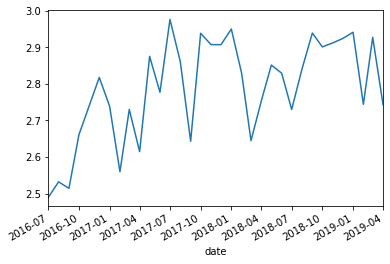

In [42]:
entropydf_bipolar_user.plot()

In [43]:
def volatility(s):
    """Computes root mean square succesive difference of series s."""
    return(np.nanmean((np.array(s[1:]) - np.array(s[:-1]))**2)**(1/2))

In [44]:
volatility(entropydf_bipolar_user)

0.1377679745074307

In [46]:
random_control_user = enough_monthly_df[enough_monthly_df.id == '260789150']
entropydf_control_user = random_control_user.groupby('date')['hour'].aggregate(entropy1)
entropydf_control_user

date
2015-02-01    2.497571
2015-03-01    2.463904
2015-07-01    2.725142
2015-08-01    2.764720
2015-09-01    2.795248
2015-12-01    2.411151
2016-01-01    2.573969
2016-07-01    2.316406
2016-08-01    2.579935
2016-09-01    2.698428
2016-10-01    2.803804
2016-11-01    2.682319
2016-12-01    2.593731
2017-01-01    2.582678
2018-05-01    2.165224
2018-06-01    2.532684
2018-08-01    2.696340
2018-09-01    2.610215
2018-10-01    2.609247
2018-11-01    2.668371
2019-01-01    2.571873
2019-02-01    2.682604
2019-03-01    2.622270
2019-04-01    2.549725
Name: hour, dtype: float64

In [47]:
random_control_user.count()

id                  2534
amount_of_months    2534
full_text           2534
hour                2534
is_control          2534
minute              2534
year                2534
month               2534
month_year_y        2534
dtype: int64

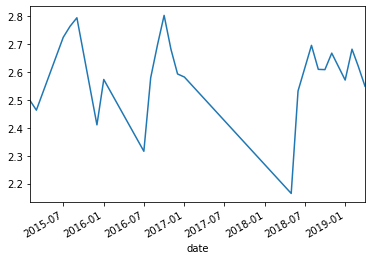

In [48]:
entropydf_control_user.plot()

In [49]:
volatility(entropydf_control_user)

0.18732018273398351

# AGGREGATE VOLATILITY PER BIPOLAR & CONTROL GROUP

In [58]:
enough_monthly_df = enough_monthly_df.reset_index().set_index('id')
enough_monthly_df.head()

,date,amount_of_months,full_text,hour,is_control,minute,year,month,month_year_y
id,,,,,,,,,
100390522,2018-04-01,25,NaN,8,0,1,2018,4,2018-04
100390522,2018-04-01,25,NaN,23,0,15,2018,4,2018-04
100390522,2018-04-01,25,NaN,2,0,57,2018,4,2018-04
100390522,2018-04-01,25,NaN,0,0,9,2018,4,2018-04
100390522,2018-04-01,25,NaN,17,0,58,2018,4,2018-04


In [59]:
entropy_df = enough_monthly_df.groupby(['is_control', 'id', 'date', 'amount_of_months'])['hour'].aggregate(
    {'entropy':entropy1})
entropy_df

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version



entropy
is_control id         date       amount_of_months          
0          100390522  2016-02-01 25                2.849938
                      2016-03-01 25                2.943155
                      2016-04-01 25                2.917264
                      2016-05-01 25                2.973526
                      2016-06-01 25                2.955496
                      2016-07-01 25                3.074730
                      2016-08-01 25                2.656187
                      2016-09-01 25                2.994027
                      2016-10-01 25                2.943512
                      2016-11-01 25                3.084417
                      2016-12-01 25                3.075202
                      2017-01-01 25                3.092915
                      2017-02-01 25                3.016547
                      2017-03-01 25                3.007014
                      2017-04-01 25                3.041387
                      2017-05-01 25                3.095632
                      2017-06-01 25                3.097004
                      2017-07-01 25                2.960668
                      2017-08-01 25                3.066396
                      2017-09-01 25                3.020871
                      2017-10-01 25                3.023612
                      2018-01-01 25                2.839958
                      2018-02-01 25                3.002451
                      2018-03-01 25                2.596834
                      2018-04-01 25                2.894704
           1021257140 2015-04-01 16                2.619386
                      2015-05-01 16                2.567694
                      2015-06-01 16                2.592627
                      2015-09-01 16                2.340311
                      2015-10-01 16                2.760594
...                                                     ...
1          99533359   2016-07-01 47                2.653149
                      2016-08-01 47                2.469497
                      2016-10-01 47                2.548066
                      2016-11-01 47                2.689872
                      2016-12-01 47                2.805683
                      2017-01-01 47                2.499703
                      2017-02-01 47                2.479268
                      2017-03-01 47                2.675855
                      2017-04-01 47                2.464238
                      2017-05-01 47                2.722733
                      2017-06-01 47                2.576690
                      2017-07-01 47                2.411559
                      2017-08-01 47                2.514750
                      2017-09-01 47                2.679864
                      2017-10-01 47                2.501754
                      2017-11-01 47                2.484073
                      2017-12-01 47                2.354407
                      2018-01-01 47                2.660370
                      2018-03-01 47                2.742966
                      2018-04-01 47                2.693162
                      2018-06-01 47                2.389510
                      2018-07-01 47                2.411348
                      2018-08-01 47                2.465136
                      2018-09-01 47                2.617386
                      2018-10-01 47                2.534818
                      2018-11-01 47                2.557041
                      2018-12-01 47                2.736673
                      2019-01-01 47                2.524771
                      2019-02-01 47                2.311389
                      2019-03-01 47                2.676463

[29562 rows x 1 columns]

In [60]:
# sns.distplot( volatility_bipolar[''] , color="red", bins = 100, label="Bipolar Group")
# sns.distplot( volatility_control[""] , color="yellos", bins = 100, label="Control Group", rug = True, rug_kws={"alpha":0.5})
# sns.set(rc={'figure.figsize':(12, 9)})

In [61]:
volatility_df = entropy_df.groupby(['is_control', 'id', 'amount_of_months'])['entropy'].aggregate(
    {'volatility':volatility})
volatility_df

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version



volatility
is_control id         amount_of_months            
0          100390522  25                  0.170106
           1021257140 16                  0.226170
           102253257  15                  0.218319
           1024631256 13                  0.216411
           1024914678 20                  0.245881
           1025511452 19                  0.131502
           1027684272 17                  0.154369
           103356365  14                  0.238382
           1051361767 26                  0.116045
           1053989688 16                  0.201382
           1057353242 14                  0.166582
           1089484346 14                  0.204407
           109717472  14                  0.222117
           1099934324 13                  0.299101
           1105273933 16                  0.135664
           1129203938 23                  0.232659
           1137840480 12                  0.096079
           1137890444 12                  0.202681
           11494952   21                  0.313905
           116177838  20                  0.208161
           11649      20                  0.151759
           116756975  18                  0.255704
           118819141  31                  0.126430
           1206053215 22                  0.193906
           123612651  16                  0.289462
           124654731  16                  0.175957
           126196633  12                  0.268685
           126519985  15                  0.255349
           127569029  13                  0.196985
           127726831  25                  0.176512
...                                            ...
1          91012041   12                  0.313775
           91160844   25                  0.294145
           91667937   12                  0.163739
           91809898   38                  0.138752
           91820476   22                  0.136974
           91835523   26                  0.161706
           919855394  18                  0.172983
           920005711  24                  0.236582
           92484971   29                  0.323059
           926063846  19                  0.146868
           92679973   32                  0.167137
           92909303   13                  0.245520
           93781907   16                  0.251920
           93850488   15                  0.226775
           94039863   21                  0.414829
           942695262  17                  0.181520
           946855278  15                  0.283903
           947904180  28                  0.481949
           95497135   18                  0.294737
           95923325   23                  0.126798
           96208912   13                  0.179279
           96311447   27                  0.157910
           96590334   26                  0.113560
           967405513  25                  0.157178
           970428594  21                  0.126039
           97561561   12                  0.141208
           98546911   12                  0.099037
           990122598  25                  0.229337
           993515436  15                  0.285098
           99533359   47                  0.184935

[1506 rows x 1 columns]

In [62]:
volatility_bipolar = volatility_df.loc[0]
volatility_control = volatility_df.loc[1]
volatility_control.head(10)

,,volatility
id,amount_of_months,
1004182135,19,0.178889
100616320,36,0.229458
1007006312,20,0.246340
100821800,20,0.151904
101014140,28,0.170964
101406741,19,0.333908
101873002,21,0.125574
1022242009,29,0.195535
102352653,12,0.258194


In [63]:
volatility_bipolar.head(10)

,,volatility
id,amount_of_months,
100390522,25,0.170106
1021257140,16,0.226170
102253257,15,0.218319
1024631256,13,0.216411
1024914678,20,0.245881
1025511452,19,0.131502
1027684272,17,0.154369
103356365,14,0.238382
1051361767,26,0.116045


In [64]:
volatility_bipolar.count()

volatility    513
dtype: int64

In [65]:
volatility_control.count()

volatility    993
dtype: int64

In [74]:
np.mean(volatility_bipolar)

volatility    0.209863
dtype: float64

In [75]:
np.mean(volatility_control)

volatility    0.22005
dtype: float64

In [76]:
## ??????????
mannwhitneyu(volatility_bipolar,volatility_control)

MannwhitneyuResult(statistic=239544.0, pvalue=0.029019998879294462)

In [77]:
## ??????????
ttest_ind(volatility_bipolar,volatility_control)

Ttest_indResult(statistic=array([-1.90593082]), pvalue=array([0.05684966]))

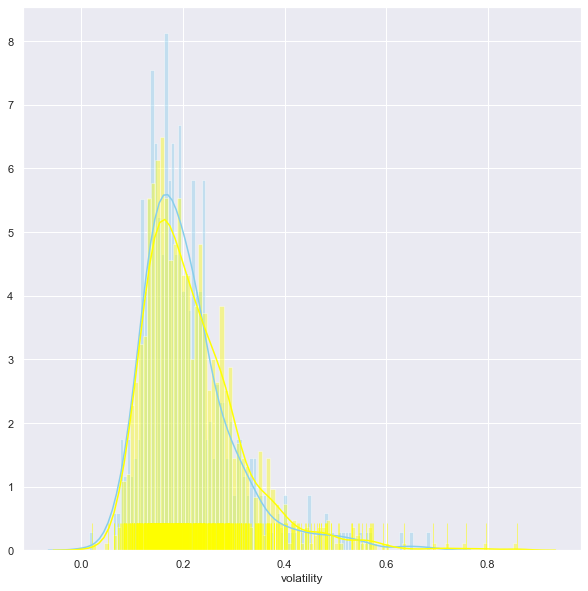

In [73]:
sns.distplot( volatility_bipolar['volatility'] , color="skyblue", bins = 100, label="Bipolar Group")
sns.distplot( volatility_control["volatility"] , color="yellow", bins = 100, label="Control Group", rug = True, rug_kws={"alpha":0.5})
sns.set(rc={'figure.figsize':(10, 10)})

In [67]:
# # Use seaborn style defaults and set the default figure size
# plt.style.use('seaborn-white')
# graph1 = volatility_bipolar['volatility'].plot(linewidth=1, marker='x', alpha=0.9, linestyle='None', figsize=(10, 6), 
#                                               color = 'palevioletred', legend=False);
# graph2 = volatility_control['volatility'].plot(linewidth=1, marker='x', alpha=0.5, linestyle='None', figsize=(10, 6), 
#                                               color = 'blue', legend=False);

# sns.set_style("ticks", 
#               {"xtick.major.size":3,
#                "ytick.major.size":3})
# #sns.set_context("paper", font_scale=2)
# plt.xticks(color='white')
                                                                                                             
# sns.despine(left=True, bottom=True)
# plt.ylabel("Volatility", fontsize=25) 
# plt.xlabel("Users", fontsize=25)
# plt.ylim(0,0.7)


In [66]:
#pre_volatility_control = random_control.groupby('date')['hour'].mean()
#pre_volatility_control

In [119]:
#w = 2
#volatility_control = pre_volatility_control.rolling(w).std() * np.sqrt(w) 
#volatility_control

In [120]:
#volatility_control.plot()

In [121]:
#ax = volatility_bipolar.plot()
#volatility_control.plot(ax=ax)

In [104]:
################## IN CASE
#groupedAD = all_data.groupby(['is_control','id','date'])['hour'].mean()
#groupedAD


#groupedAD = all_data.groupby(['is_control', 'id', 'month_year'])['hour'].
#filteredAD = groupedAD.groupby(['is_control', 'id', 'month_year'])['hour'].count()
#filteredAD

is_control  id                   date      
0           10006872             2018-09-01    12.717325
                                 2018-10-01    13.919540
                                 2018-11-01    13.525773
                                 2018-12-01    11.441606
                                 2019-01-01    11.641379
                                 2019-02-01    13.289575
                                 2019-03-01    13.672131
                                 2019-04-01    12.965753
            1001172883115335685  2018-11-01    14.195991
                                 2018-12-01    14.838710
                                 2019-01-01    14.278761
                                 2019-02-01    13.913189
                                 2019-03-01    15.063452
                                 2019-04-01    13.930769
            1001590695822475265  2018-10-01    12.630319
                                 2018-11-01     8.919192
                                 2018-12-01 